In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv('./data/train_3406.csv')
data_test = pd.read_csv('./data/test_3406.csv')

In [3]:
#技術指標
#Moving Average  
def MA(df, n):  
    MA = df.rolling(n).mean()
    return MA

#均價線
def AVL(df):#, tick_N):
    AVL =  pd.DataFrame(data = np.zeros((len(df), 1)), index = df.index, columns = ['AVL'])  
    AVL['AVL'] = np.cumsum(df['DealPrice']*df['DealQty']) / np.cumsum(df['DealQty'])
    AVL['%AVL'] = df['mid1'] / AVL['AVL'] - 1
    return AVL

#布林通道
def BBANDS(df, n, multiple, tick_N):  
    MA = df.rolling(n).mean()
    #%change
    MA_ = MA / MA.shift(tick_N) -1
    MSD = df.rolling(n).std()
    ub1 =  MA + multiple * MSD
    #%change
    ub1_ = ub1 / ub1.shift(tick_N) -1
    uB1 = pd.DataFrame(ub1_, index = df.index, columns = df.columns)  
    lb1 =  MA - multiple * MSD
    #%change
    lb1_ = lb1 / lb1.shift(tick_N) -1
    lB1 = pd.DataFrame(lb1_, index = df.index, columns = df.columns)  
    b2 = (df - MA + multiple * MSD) / (2 * multiple * MSD)  
    B2 = pd.DataFrame(b2, index = df.index, columns = df.columns)  
    BBAND = pd.concat([uB1, lB1, B2], keys = ['UpperBand', 'LowerBand', '%B'], axis = 1)
    BBAND.columns = ['UpperBand', 'LowerBand', '%B']
    return BBAND

#MACD, MACD Signal and MACD difference  
def MACD(df, n_fast, n_slow, C_price_name='mid1'):   
    EMAfast = df[C_price_name].ewm(span = n_fast, min_periods = n_slow - 1).mean() 
    EMAslow = df[C_price_name].ewm(span = n_slow, min_periods = n_slow - 1).mean() 
    #短EMA-長EMA
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))  
    MACDsign = pd.Series(MACD.ewm(span = 9, min_periods = 8).mean(), name = 'MACDsign_' + str(n_fast) + '_' + str(n_slow))  
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))  
    MACD = pd.concat([MACD, MACDsign, MACDdiff], axis = 1)
    return MACD

#generate features
def AlphaGenerate_Tick(original_data,bb=False,avl=False,spread=False,macd=False,price_diff=False,
                       price_mean=False,qty_mean=False,acc_diff=False,dt1p=False,dt5p=False,dt10p=False,
                      cross1=False,cross5=False,cross10=False,spread_pq=False,price_diff_pq=False,
                      spread_pct_pq=False,pq_mean=False,acc_diff_pq=False,dt1_pq=False,dt5_pq=False,dt10_pq=False,
                      ma=False,dt1q=False,dt5q=False,dt10q=False):
    ############################################################################################################################
    #需要預先處裡的東西放這邊
    #build Date column
    #original_data['Date'] = pd.to_datetime(original_data['TxTime'])
    #original_data['Date'] = [str(x)[0:10] for x in original_data['Date']]
    #df to save X
    X = pd.DataFrame()
    #copy
    data=original_data.copy()
    #mid
    data['mid1'] = (data['Ask1'] + data['Bid1']) / 2
    data['mid2'] = (data['Ask2'] + data['Bid2']) / 2
    data['mid3'] = (data['Ask3'] + data['Bid3']) / 2
    data['mid4'] = (data['Ask4'] + data['Bid4']) / 2
    data['mid5'] = (data['Ask5'] + data['Bid5']) / 2
    #some index's ask1 = 0, we change that mid1 to bid1
    idx = data[data['Ask1'] == 0].index
    for i in idx:
        data['mid1'].iloc[i] = data['Bid1'].iloc[i]
    #委買委賣比，判斷買賣邊力道
    data['Ask1_value'] = data['AskQty1']/(data['BidQty1']+data['AskQty1'])
    data['Ask2_value'] = data['AskQty2']/(data['BidQty2']+data['AskQty2'])
    data['Ask3_value'] = data['AskQty3']/(data['BidQty3']+data['AskQty3'])
    data['Ask4_value'] = data['AskQty4']/(data['BidQty4']+data['AskQty4'])
    data['Ask5_value'] = data['AskQty5']/(data['BidQty5']+data['AskQty5'])
    data['Bid1_value'] = data['BidQty1']/(data['BidQty1']+data['AskQty1'])
    data['Bid2_value'] = data['BidQty2']/(data['BidQty2']+data['AskQty2'])
    data['Bid3_value'] = data['BidQty3']/(data['BidQty3']+data['AskQty3'])
    data['Bid4_value'] = data['BidQty4']/(data['BidQty4']+data['AskQty4'])
    data['Bid5_value'] = data['BidQty5']/(data['BidQty5']+data['AskQty5'])
    #ask and askqty <-> bid and bidqty if one side = 0
    data['Ask1'][data['Ask1']==0]=data['Bid1']
    data['Ask2'][data['Ask2']==0]=data['Bid2']
    data['Ask3'][data['Ask3']==0]=data['Bid3']
    data['Ask4'][data['Ask4']==0]=data['Bid4']
    data['Ask5'][data['Ask5']==0]=data['Bid5']
    data['AskQty1'][data['AskQty1']==0]=data['BidQty1']
    data['AskQty2'][data['AskQty2']==0]=data['BidQty2']
    data['AskQty3'][data['AskQty3']==0]=data['BidQty3']
    data['AskQty4'][data['AskQty4']==0]=data['BidQty4']
    data['AskQty5'][data['AskQty5']==0]=data['BidQty5']
    data['Bid1'][data['Bid1']==0]=data['Ask1']
    data['Bid2'][data['Bid2']==0]=data['Ask2']
    data['Bid3'][data['Bid3']==0]=data['Ask3']
    data['Bid4'][data['Bid4']==0]=data['Ask4']
    data['Bid5'][data['Bid5']==0]=data['Ask5']
    data['BidQty1'][data['BidQty1']==0]=data['AskQty1']
    data['BidQty2'][data['BidQty2']==0]=data['AskQty2']
    data['BidQty3'][data['BidQty3']==0]=data['AskQty3']
    data['BidQty4'][data['BidQty4']==0]=data['AskQty4']
    data['BidQty5'][data['BidQty5']==0]=data['AskQty5']
    #df to save
    #df_date = pd.DataFrame()
    #date_idx = data['Date'].unique()
    #value(price*quantity)
    #data['Ask1_value'] = data['Ask1']*data['AskQty1']
    #data['Ask2_value'] = data['Ask2']*data['AskQty2']
    #data['Ask3_value'] = data['Ask3']*data['AskQty3']
    #data['Ask4_value'] = data['Ask4']*data['AskQty4']
    #data['Ask5_value'] = data['Ask5']*data['AskQty5']
    #data['Bid1_value'] = data['Bid1']*data['BidQty1']
    #data['Bid2_value'] = data['Bid2']*data['BidQty2']
    #data['Bid3_value'] = data['Bid3']*data['BidQty3']
    #data['Bid4_value'] = data['Bid4']*data['BidQty4']
    #data['Bid5_value'] = data['Bid5']*data['BidQty5']
    ############################################################################################################################
    #因子放這邊
    #不用考慮換日的因子 
    #MA
    if ma == True:
        X['MA50_ask1']=MA(data['Ask1_value'], 50)-data['Ask1_value']
        X['MA50_ask2']=MA(data['Ask2_value'], 50)-data['Ask2_value']
        X['MA50_ask3']=MA(data['Ask3_value'], 50)-data['Ask3_value']
        X['MA50_ask4']=MA(data['Ask4_value'], 50)-data['Ask4_value']
        X['MA50_ask5']=MA(data['Ask5_value'], 50)-data['Ask5_value']
        X['MA50_bid1']=MA(data['Bid1_value'], 50)-data['Bid1_value']
        X['MA50_bid2']=MA(data['Bid2_value'], 50)-data['Bid2_value']
        X['MA50_bid3']=MA(data['Bid3_value'], 50)-data['Bid3_value']
        X['MA50_bid4']=MA(data['Bid4_value'], 50)-data['Bid4_value']
        X['MA50_bid5']=MA(data['Bid5_value'], 50)-data['Bid5_value']
        X['MA100_ask1']=MA(data['Ask1_value'], 100)-data['Ask1_value']
        X['MA100_ask2']=MA(data['Ask2_value'], 100)-data['Ask2_value']
        X['MA100_ask3']=MA(data['Ask3_value'], 100)-data['Ask3_value']
        X['MA100_ask4']=MA(data['Ask4_value'], 100)-data['Ask4_value']
        X['MA100_ask5']=MA(data['Ask5_value'], 100)-data['Ask5_value']
        X['MA100_bid1']=MA(data['Bid1_value'], 100)-data['Bid1_value']
        X['MA100_bid2']=MA(data['Bid2_value'], 100)-data['Bid2_value']
        X['MA100_bid3']=MA(data['Bid3_value'], 100)-data['Bid3_value']
        X['MA100_bid4']=MA(data['Bid4_value'], 100)-data['Bid4_value']
        X['MA100_bid5']=MA(data['Bid5_value'], 100)-data['Bid5_value']
        X['MA10_ab1']=MA(data['Ask1_value'], 10) - MA(data['Bid1_value'], 10)
        X['MA10_ab2']=MA(data['Ask2_value'], 10) - MA(data['Bid2_value'], 10)
        X['MA10_ab3']=MA(data['Ask3_value'], 10) - MA(data['Bid3_value'], 10)
        X['MA10_ab4']=MA(data['Ask4_value'], 10) - MA(data['Bid4_value'], 10)
        X['MA10_ab5']=MA(data['Ask5_value'], 10) - MA(data['Bid5_value'], 10)
        X['MA20_ab1']=MA(data['Ask1_value'], 20) - MA(data['Bid1_value'], 20)
        X['MA20_ab2']=MA(data['Ask2_value'], 20) - MA(data['Bid2_value'], 20)
        X['MA20_ab3']=MA(data['Ask3_value'], 20) - MA(data['Bid3_value'], 20)
        X['MA20_ab4']=MA(data['Ask4_value'], 20) - MA(data['Bid4_value'], 20)
        X['MA20_ab5']=MA(data['Ask5_value'], 20) - MA(data['Bid5_value'], 20)
        X['MA30_ab1']=MA(data['Ask1_value'], 30) - MA(data['Bid1_value'], 30)
        X['MA30_ab2']=MA(data['Ask2_value'], 30) - MA(data['Bid2_value'], 30)
        X['MA30_ab3']=MA(data['Ask3_value'], 30) - MA(data['Bid3_value'], 30)
        X['MA30_ab4']=MA(data['Ask4_value'], 30) - MA(data['Bid4_value'], 30)
        X['MA30_ab5']=MA(data['Ask5_value'], 30) - MA(data['Bid5_value'], 30)
        X['MA50_ab1']=MA(data['Ask1_value'], 50) - MA(data['Bid1_value'], 50)
        X['MA50_ab2']=MA(data['Ask2_value'], 50) - MA(data['Bid2_value'], 50)
        X['MA50_ab3']=MA(data['Ask3_value'], 50) - MA(data['Bid3_value'], 50)
        X['MA50_ab4']=MA(data['Ask4_value'], 50) - MA(data['Bid4_value'], 50)
        X['MA50_ab5']=MA(data['Ask5_value'], 50) - MA(data['Bid5_value'], 50)
        X['MA100_ab1']=MA(data['Ask1_value'], 100) - MA(data['Bid1_value'], 100)
        X['MA100_ab2']=MA(data['Ask2_value'], 100) - MA(data['Bid2_value'], 100)
        X['MA100_ab3']=MA(data['Ask3_value'], 100) - MA(data['Bid3_value'], 100)
        X['MA100_ab4']=MA(data['Ask4_value'], 100) - MA(data['Bid4_value'], 100)
        X['MA100_ab5']=MA(data['Ask5_value'], 100) - MA(data['Bid5_value'], 100)
    #布林通道
    if bb == True:
        X = pd.concat([X, BBANDS(data[['mid1']], 100, 5, 10)], axis = 1)
    #均價線
    if avl == True:
        X = pd.concat([X, AVL(data)], axis = 1)
    #MACD
    if macd == True:
        X = pd.concat([X, MACD(data, 12, 26, C_price_name='mid1')], axis = 1)
    #spread of price
    if spread == True:
        X['spread1'] = data['Ask1'] - data['Bid1']
        X['spread2'] = data['Ask2'] - data['Bid2']
        X['spread3'] = data['Ask3'] - data['Bid3']
        X['spread4'] = data['Ask4'] - data['Bid4']
        X['spread5'] = data['Ask5'] - data['Bid5']
    #pct change of value
    #if spread_pct_pq == True:
    #    X['spread1_pct_pq'] = (data['Ask1_value'] / data['Bid1_value']) -1
    #    X['spread2_pct_pq'] = (data['Ask2_value'] / data['Bid2_value']) -1
    #    X['spread3_pct_pq'] = (data['Ask3_value'] / data['Bid3_value']) -1
    #    X['spread4_pct_pq'] = (data['Ask4_value'] / data['Bid4_value']) -1
    #    X['spread5_pct_pq'] = (data['Ask5_value'] / data['Bid5_value']) -1
    #spread of value
    if spread_pq == True:
        X['spread1_pq'] = data['Ask1_value'] - data['Bid1_value']
        X['spread2_pq'] = data['Ask2_value'] - data['Bid2_value'] 
        X['spread3_pq'] = data['Ask3_value'] - data['Bid3_value'] 
        X['spread4_pq'] = data['Ask4_value'] - data['Bid4_value'] 
        X['spread5_pq'] = data['Ask5_value'] - data['Bid5_value'] 
    #price diff
    if price_diff == True:
        X['a51_diff'] = data['Ask5'] - data['Ask1']
        X['b15_diff'] = data['Bid1'] - data['Bid5']
        X['a21_diff_abs'] = np.abs(data['Ask2'] - data['Ask1'])
        X['a32_diff_abs'] = np.abs(data['Ask3'] - data['Ask2'])
        X['a43_diff_abs'] = np.abs(data['Ask4'] - data['Ask3'])
        X['a54_diff_abs'] = np.abs(data['Ask5'] - data['Ask4'])
        X['b21_diff_abs'] = np.abs(data['Bid2'] - data['Bid1'])
        X['b32_diff_abs'] = np.abs(data['Bid3'] - data['Bid2'])
        X['b43_diff_abs'] = np.abs(data['Bid4'] - data['Bid3'])
        X['b54_diff_abs'] = np.abs(data['Bid5'] - data['Bid4'])
    #value diff
    if price_diff_pq == True:
        X['a51_diff_pq'] = data['Ask5_value'] - data['Ask1_value']
        X['b15_diff_pq'] = data['Bid1_value'] - data['Bid5_value']
        X['a21_diff_pq'] = data['Ask2_value'] - data['Ask1_value']
        X['a32_diff_pq'] = data['Ask3_value'] - data['Ask2_value']
        X['a43_diff_pq'] = data['Ask4_value'] - data['Ask3_value']
        X['a54_diff_pq'] = data['Ask5_value'] - data['Ask4_value']
        X['b21_diff_pq'] = data['Bid2_value'] - data['Bid1_value']
        X['b32_diff_pq'] = data['Bid3_value'] - data['Bid2_value']
        X['b43_diff_pq'] = data['Bid4_value'] - data['Bid3_value']
        X['b54_diff_pq'] = data['Bid5_value'] - data['Bid4_value']
    #price mean
    if price_mean == True:
        X['a_mean'] = (data['Ask1'] +data['Ask2'] +data['Ask3'] +data['Ask4'] +data['Ask5']) / 5
        X['b_mean'] = (data['Bid1'] +data['Bid2'] +data['Bid3'] +data['Bid4'] +data['Bid5']) / 5
    #quantity mean
    if qty_mean == True:
        X['aq_mean'] = (data['AskQty1'] +data['AskQty2'] +data['AskQty3'] +data['AskQty4'] +data['AskQty5']) / 5
        X['bq_mean'] = (data['BidQty1'] +data['BidQty2'] +data['BidQty3'] +data['BidQty4'] +data['BidQty5']) / 5
    #value mean
    if pq_mean == True:
        X['a_pq_mean'] = (data['Ask1_value']+data['Ask2_value']+data['Ask3_value']+data['Ask4_value']+data['Ask5_value'])/5
        X['b_pq_mean'] = (data['Bid1_value']+data['Bid2_value']+data['Bid3_value']+data['Bid4_value']+data['Bid5_value'])/5
    #accumulative difference of price and quantity
    if acc_diff == True:
        X['p_acc_diff'] = (data['Ask1'] - data['Bid1']) +(data['Ask2'] - data['Bid2']) + (data['Ask3'] - data['Bid3']) + (data['Ask4'] - data['Bid4']) + (data['Ask5'] - data['Bid5'])
        X['q_acc_diff'] = (data['AskQty1'] - data['BidQty1']) +(data['AskQty2'] - data['BidQty2']) + (data['AskQty3'] - data['BidQty3']) + (data['AskQty4'] - data['BidQty4']) + (data['AskQty5'] - data['BidQty5'])
    #value accumulative difference
    if acc_diff_pq == True:
        X['p_acc_diff_pq'] = (data['Ask1_value'] - data['Bid1_value']) +(data['Ask2_value'] - data['Bid2_value']) + (data['Ask3_value'] - data['Bid3_value']) + (data['Ask4_value'] - data['Bid4_value']) + (data['Ask5_value'] - data['Bid5_value'])
    ############################################################################################################################
    #要考慮換日的因子
    #shift 1 5 10 (price, quantity, value)
    if dt1p == True:
    #1 tick
        X['da1_dt_1'] = data['Ask1']-data.groupby('Date')['Ask1'].shift(1)
        X['da2_dt_1'] = data['Ask2']-data.groupby('Date')['Ask2'].shift(1)
        X['da3_dt_1'] = data['Ask3']-data.groupby('Date')['Ask3'].shift(1)
        X['da4_dt_1'] = data['Ask4']-data.groupby('Date')['Ask4'].shift(1)
        X['da5_dt_1'] = data['Ask5']-data.groupby('Date')['Ask5'].shift(1)
        X['db1_dt_1'] = data['Bid1']-data.groupby('Date')['Bid1'].shift(1)
        X['db2_dt_1'] = data['Bid2']-data.groupby('Date')['Bid2'].shift(1)
        X['db3_dt_1'] = data['Bid3']-data.groupby('Date')['Bid3'].shift(1)
        X['db4_dt_1'] = data['Bid4']-data.groupby('Date')['Bid4'].shift(1)
        X['db5_dt_1'] = data['Bid5']-data.groupby('Date')['Bid5'].shift(1)
        #fillna to 0
        X[['da1_dt_1','da2_dt_1','da3_dt_1','da4_dt_1','da5_dt_1','db1_dt_1','db2_dt_1','db3_dt_1','db4_dt_1','db5_dt_1']] = X[['da1_dt_1','da2_dt_1','da3_dt_1','da4_dt_1','da5_dt_1','db1_dt_1','db2_dt_1','db3_dt_1','db4_dt_1','db5_dt_1']].fillna(value = 0)
        
    if dt1_pq == True:
    #1 tick
        X['da1_dt_1_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(1)
        X['da2_dt_1_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(1)
        X['da3_dt_1_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(1)
        X['da4_dt_1_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(1)
        X['da5_dt_1_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(1)
        X['db1_dt_1_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(1)
        X['db2_dt_1_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(1)
        X['db3_dt_1_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(1)
        X['db4_dt_1_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(1)
        X['db5_dt_1_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(1)
    if dt5p == True:
    #5 ticks
        X['da1_dt_5'] = data['Ask1']-data.groupby('Date')['Ask1'].shift(5)
        X['da2_dt_5'] = data['Ask2']-data.groupby('Date')['Ask2'].shift(5)
        X['da3_dt_5'] = data['Ask3']-data.groupby('Date')['Ask3'].shift(5)
        X['da4_dt_5'] = data['Ask4']-data.groupby('Date')['Ask4'].shift(5)
        X['da5_dt_5'] = data['Ask5']-data.groupby('Date')['Ask5'].shift(5)
        X['db1_dt_5'] = data['Bid1']-data.groupby('Date')['Bid1'].shift(5)
        X['db2_dt_5'] = data['Bid2']-data.groupby('Date')['Bid2'].shift(5)
        X['db3_dt_5'] = data['Bid3']-data.groupby('Date')['Bid3'].shift(5)
        X['db4_dt_5'] = data['Bid4']-data.groupby('Date')['Bid4'].shift(5)
        X['db5_dt_5'] = data['Bid5']-data.groupby('Date')['Bid5'].shift(5)
        #fill na to 0
        X[['da1_dt_5','da2_dt_5','da3_dt_5','da4_dt_5','da5_dt_5','db1_dt_5','db2_dt_5','db3_dt_5','db4_dt_5','db5_dt_5']] = X[['da1_dt_5','da2_dt_5','da3_dt_5','da4_dt_5','da5_dt_5','db1_dt_5','db2_dt_5','db3_dt_5','db4_dt_5','db5_dt_5']].fillna(value = 0)
    if dt5_pq == True:
    #5 tick
        X['da1_dt_5_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(5)
        X['da2_dt_5_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(5)
        X['da3_dt_5_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(5)
        X['da4_dt_5_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(5)
        X['da5_dt_5_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(5)
        X['db1_dt_5_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(5)
        X['db2_dt_5_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(5)
        X['db3_dt_5_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(5)
        X['db4_dt_5_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(5)
        X['db5_dt_5_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(5)                                            
    if dt10p == True:
    #10 ticks
        X['da1_dt_10'] = data['Ask1']-data.groupby('Date')['Ask1'].shift(10)
        X['da2_dt_10'] = data['Ask2']-data.groupby('Date')['Ask2'].shift(10)
        X['da3_dt_10'] = data['Ask3']-data.groupby('Date')['Ask3'].shift(10)
        X['da4_dt_10'] = data['Ask4']-data.groupby('Date')['Ask4'].shift(10)
        X['da5_dt_10'] = data['Ask5']-data.groupby('Date')['Ask5'].shift(10)
        X['db1_dt_10'] = data['Bid1']-data.groupby('Date')['Bid1'].shift(10)
        X['db2_dt_10'] = data['Bid2']-data.groupby('Date')['Bid2'].shift(10)
        X['db3_dt_10'] = data['Bid3']-data.groupby('Date')['Bid3'].shift(10)
        X['db4_dt_10'] = data['Bid4']-data.groupby('Date')['Bid4'].shift(10)
        X['db5_dt_10'] = data['Bid5']-data.groupby('Date')['Bid5'].shift(10)
        #fill na to 0
        X[['da1_dt_10','da2_dt_10','da3_dt_10','da4_dt_10','da5_dt_10','db1_dt_10','db2_dt_10','db3_dt_10','db4_dt_10','db5_dt_10']] = X[['da1_dt_10','da2_dt_10','da3_dt_10','da4_dt_10','da5_dt_10','db1_dt_10','db2_dt_10','db3_dt_10','db4_dt_10','db5_dt_10']].fillna(value = 0)
    if dt10_pq == True:
    #10 tick
        X['da1_dt_10_pq'] = data['Ask1_value']-data.groupby('Date')['Ask1_value'].shift(10)
        X['da2_dt_10_pq'] = data['Ask2_value']-data.groupby('Date')['Ask2_value'].shift(10)
        X['da3_dt_10_pq'] = data['Ask3_value']-data.groupby('Date')['Ask3_value'].shift(10)
        X['da4_dt_10_pq'] = data['Ask4_value']-data.groupby('Date')['Ask4_value'].shift(10)
        X['da5_dt_10_pq'] = data['Ask5_value']-data.groupby('Date')['Ask5_value'].shift(10)
        X['db1_dt_10_pq'] = data['Bid1_value']-data.groupby('Date')['Bid1_value'].shift(10)
        X['db2_dt_10_pq'] = data['Bid2_value']-data.groupby('Date')['Bid2_value'].shift(10)
        X['db3_dt_10_pq'] = data['Bid3_value']-data.groupby('Date')['Bid3_value'].shift(10)
        X['db4_dt_10_pq'] = data['Bid4_value']-data.groupby('Date')['Bid4_value'].shift(10)
        X['db5_dt_10_pq'] = data['Bid5_value']-data.groupby('Date')['Bid5_value'].shift(10)                                           
    #quantity
    if dt1q == True:
    #1 tick
        X['daq1_dt_1'] = data['AskQty1']-data.groupby('Date')['AskQty1'].shift(1)
        X['daq2_dt_1'] = data['AskQty2']-data.groupby('Date')['AskQty2'].shift(1)
        X['daq3_dt_1'] = data['AskQty3']-data.groupby('Date')['AskQty3'].shift(1)
        X['daq4_dt_1'] = data['AskQty4']-data.groupby('Date')['AskQty4'].shift(1)
        X['daq5_dt_1'] = data['AskQty5']-data.groupby('Date')['AskQty5'].shift(1)
        X['dbq1_dt_1'] = data['BidQty1']-data.groupby('Date')['BidQty1'].shift(1)
        X['dbq2_dt_1'] = data['BidQty2']-data.groupby('Date')['BidQty2'].shift(1)
        X['dbq3_dt_1'] = data['BidQty3']-data.groupby('Date')['BidQty3'].shift(1)
        X['dbq4_dt_1'] = data['BidQty4']-data.groupby('Date')['BidQty4'].shift(1)
        X['dbq5_dt_1'] = data['BidQty5']-data.groupby('Date')['BidQty5'].shift(1)
        #fill na to 0
        X[['daq1_dt_1','daq2_dt_1','daq3_dt_1','daq4_dt_1','daq5_dt_1','dbq1_dt_1','dbq2_dt_1','dbq3_dt_1','dbq4_dt_1','dbq5_dt_1']] = X[['daq1_dt_1','daq2_dt_1','daq3_dt_1','daq4_dt_1','daq5_dt_1','dbq1_dt_1','dbq2_dt_1','dbq3_dt_1','dbq4_dt_1','dbq5_dt_1']].fillna(value = 0)
    if dt5q == True:
    #5 ticks
        X['daq1_dt_5'] = data['AskQty1']-data.groupby('Date')['AskQty1'].shift(5)
        X['daq2_dt_5'] = data['AskQty2']-data.groupby('Date')['AskQty2'].shift(5)
        X['daq3_dt_5'] = data['AskQty3']-data.groupby('Date')['AskQty3'].shift(5)
        X['daq4_dt_5'] = data['AskQty4']-data.groupby('Date')['AskQty4'].shift(5)
        X['daq5_dt_5'] = data['AskQty5']-data.groupby('Date')['AskQty5'].shift(5)
        X['dbq1_dt_5'] = data['BidQty1']-data.groupby('Date')['BidQty1'].shift(5)
        X['dbq2_dt_5'] = data['BidQty2']-data.groupby('Date')['BidQty2'].shift(5)
        X['dbq3_dt_5'] = data['BidQty3']-data.groupby('Date')['BidQty3'].shift(5)
        X['dbq4_dt_5'] = data['BidQty4']-data.groupby('Date')['BidQty4'].shift(5)
        X['dbq5_dt_5'] = data['BidQty5']-data.groupby('Date')['BidQty5'].shift(5)
        #fill na to 0
        X[['daq1_dt_5','daq2_dt_5','daq3_dt_5','daq4_dt_5','daq5_dt_5','dbq1_dt_5','dbq2_dt_5','dbq3_dt_5','dbq4_dt_5','dbq5_dt_5']] = X[['daq1_dt_5','daq2_dt_5','daq3_dt_5','daq4_dt_5','daq5_dt_5','dbq1_dt_5','dbq2_dt_5','dbq3_dt_5','dbq4_dt_5','dbq5_dt_5']].fillna(value = 0)
    if dt10q == True:
    #10 ticks
        X['daq1_dt_10'] = data['AskQty1']-data.groupby('Date')['AskQty1'].shift(10)
        X['daq2_dt_10'] = data['AskQty2']-data.groupby('Date')['AskQty2'].shift(10)
        X['daq3_dt_10'] = data['AskQty3']-data.groupby('Date')['AskQty3'].shift(10)
        X['daq4_dt_10'] = data['AskQty4']-data.groupby('Date')['AskQty4'].shift(10)
        X['daq5_dt_10'] = data['AskQty5']-data.groupby('Date')['AskQty5'].shift(10)
        X['dbq1_dt_10'] = data['BidQty1']-data.groupby('Date')['BidQty1'].shift(10)
        X['dbq2_dt_10'] = data['BidQty2']-data.groupby('Date')['BidQty2'].shift(10)
        X['dbq3_dt_10'] = data['BidQty3']-data.groupby('Date')['BidQty3'].shift(10)
        X['dbq4_dt_10'] = data['BidQty4']-data.groupby('Date')['BidQty4'].shift(10)
        X['dbq5_dt_10'] = data['BidQty5']-data.groupby('Date')['BidQty5'].shift(10)
        #fill na to 0
        X[['daq1_dt_10','daq2_dt_10','daq3_dt_10','daq4_dt_10','daq5_dt_10','dbq1_dt_10','dbq2_dt_10','dbq3_dt_10','dbq4_dt_10','dbq5_dt_10']] = X[['daq1_dt_10','daq2_dt_10','daq3_dt_10','daq4_dt_10','daq5_dt_10','dbq1_dt_10','dbq2_dt_10','dbq3_dt_10','dbq4_dt_10','dbq5_dt_10']].fillna(value = 0)    
    #features crosses
    #dt1
    if (cross1 == True) and (dt1p == True) and (dt1q == True):
        #ask
        X['aq1dt1_cross'] = X['da1_dt_1'] * X['daq1_dt_1']
        X['aq2dt1_cross'] = X['da2_dt_1'] * X['daq2_dt_1']
        X['aq3dt1_cross'] = X['da3_dt_1'] * X['daq3_dt_1']
        X['aq4dt1_cross'] = X['da4_dt_1'] * X['daq4_dt_1']
        X['aq5dt1_cross'] = X['da5_dt_1'] * X['daq5_dt_1']
        #bid
        X['bq1dt1_cross'] = X['db1_dt_1'] * X['dbq1_dt_1']
        X['bq2dt1_cross'] = X['db2_dt_1'] * X['dbq2_dt_1']
        X['bq3dt1_cross'] = X['db3_dt_1'] * X['dbq3_dt_1']
        X['bq4dt1_cross'] = X['db4_dt_1'] * X['dbq4_dt_1']
        X['bq5dt1_cross'] = X['db5_dt_1'] * X['dbq5_dt_1']
    #dt5
    if (cross5 == True) and (dt5p == True) and (dt5q == True):
        #ask
        X['aq1dt5_cross'] = X['da1_dt_5'] * X['daq1_dt_5']
        X['aq2dt5_cross'] = X['da2_dt_5'] * X['daq2_dt_5']
        X['aq3dt5_cross'] = X['da3_dt_5'] * X['daq3_dt_5']
        X['aq4dt5_cross'] = X['da4_dt_5'] * X['daq4_dt_5']
        X['aq5dt5_cross'] = X['da5_dt_5'] * X['daq5_dt_5']
        #bid
        X['bq1dt5_cross'] = X['db1_dt_5'] * X['dbq1_dt_5']
        X['bq2dt5_cross'] = X['db2_dt_5'] * X['dbq2_dt_5']
        X['bq3dt5_cross'] = X['db3_dt_5'] * X['dbq3_dt_5']
        X['bq4dt5_cross'] = X['db4_dt_5'] * X['dbq4_dt_5']
        X['bq5dt5_cross'] = X['db5_dt_5'] * X['dbq5_dt_5']
    #dt10
    if (cross10 == True) and (dt10p == True) and (dt10q == True):
        #ask
        X['aq1dt10_cross'] = X['da1_dt_10'] * X['daq1_dt_10']
        X['aq2dt10_cross'] = X['da2_dt_10'] * X['daq2_dt_10']
        X['aq3dt10_cross'] = X['da3_dt_10'] * X['daq3_dt_10']
        X['aq4dt10_cross'] = X['da4_dt_10'] * X['daq4_dt_10']
        X['aq5dt10_cross'] = X['da5_dt_10'] * X['daq5_dt_10']
        #bid
        X['bq1dt10_cross'] = X['db1_dt_10'] * X['dbq1_dt_10']
        X['bq2dt10_cross'] = X['db2_dt_10'] * X['dbq2_dt_10']
        X['bq3dt10_cross'] = X['db3_dt_10'] * X['dbq3_dt_10']
        X['bq4dt10_cross'] = X['db4_dt_10'] * X['dbq4_dt_10']
        X['bq5dt10_cross'] = X['db5_dt_10'] * X['dbq5_dt_10']
    df = pd.concat([data, X], axis = 1)
    df = df.dropna()
    df = df.reset_index(drop = True)
    X = X.dropna()
    X = X.reset_index(drop = True)
    return X, df

#normalize
def normalize(df):
    norm = df.apply(lambda x: x / (np.std(x)))
    return norm

#scale back to the true range
def true_range(df, x, response):
    X = x * np.std(df[response])
    return X

#rolling windows
def train_windows(df, response, ref_day=10, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day+1):
        #扣掉response
        #記得最後一行要放response
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day-1:i+ref_day][response]))
    return np.array(X_train), np.array(Y_train)

#LSTM (when add the drop out layer in order to deal with overfitting)
def lstm_stock_model(shape):
    model = Sequential()
    #return sequence = True -> means the network will have long memory
    #first layer
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    #first drop out layer(drop 50% of the previous one to avoid over-fitting)
    model.add(Dropout(0.5))
    #second layer
    model.add(LSTM(256, return_sequences=True))
    #second drop out layer
    model.add(Dropout(0.5))
    #add dense in every time step, dimension -> 1
    model.add(TimeDistributed(Dense(1)))
    #third drop out layer
    model.add(Dropout(0.5))
    #flatten: 多維 -> 一維
    model.add(Flatten())
    #forth drop out layer
    #model.add(Dropout(0.5))
    #dense layer
    model.add(Dense(10,activation='linear'))
    #1 -> output dimension
    model.add(Dense(1,activation='linear'))
    #change learning rate 0.001 -> 0.0005
    adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    model.compile(loss="mean_squared_error", optimizer=adam,metrics=['mean_squared_error'])
    #using MSE
    #model.compile(loss="mean_squared_error", optimizer="adam",metrics=['mean_squared_error'])
    model.summary()
    return model

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)
    return r_squared

#record transaction
def record_transaction(para, date, tick, action_side, price, equity_value, transaction_history):
    info = {
                'Date': date,
                'tick': tick,
                'Action': action_side,
                'Price': price,
                'Equity_value': equity_value
            }
    if para in transaction_history:
        transaction_history[para].append(info)
    else:
        transaction_history.update({para: [info]})    
    
    return transaction_history

#performance
def performance(equity_value_, transaction):
    #return
    Return = equity_value_.iloc[-1][0]
    print('return:', Return)
    #vol
    Std = equity_value_.std()[0]
    print('std:', Std)
    #sharp ratio
    Sharp_ratio = (Return - 0.0052) / Std
    print('sharp ratio:', Sharp_ratio)
    #nums of trading
    Trades = len(transaction) / 2
    print('trades:', Trades)
    #odds ratio
    R = 0
    for i in range(len(transaction)):
        if transaction[i]['Equity_value'] > 0:
            R += 1
    Odd = R / (len(transaction) / 2)
    print('odds ratio:', Odd)
    #mdd
    Mdd = (equity_value_.cummax() - equity_value_).max()[0]
    print('mdd:', Mdd)
    #skew
    Skew = equity_value_.skew()[0]
    print('skewness:', Skew)
     
    return Return, Std, Sharp_ratio, Trades, Odd, Mdd, Skew

#model performance
def model_performance(y, f):
    tot = np.sum(np.square(y - np.mean(y)))
    res = np.sum(np.square(y - f))
    r_squared = 1 - res / tot
    mse = np.mean(np.square(y - f)) * (1 / len(y))
    print('MSE:', mse)
    print('r-squared:', r_squared)
    return r_squared

#strategy
def strategy(df_train, paras):
    #adding hard stop 
    #main strategy (train set)
    #record transaction
    transaction_history1 = {}
    #record equity values
    equity_value_1 = pd.DataFrame()
    #record each returns
    #each_return1 = pd.DataFrame()
    #record unrealized gain
    unrealized_1 = pd.DataFrame()
    for l in range(len(paras)):
        df_train['side'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
        for j in range(len(df_train)):
            if df_train['pred_return'].iloc[j] > paras[l][0]:
                #long side
                df_train['side'].iloc[j] = 1
            elif df_train['pred_return'].iloc[j] < paras[l][1]:
                #short side
                df_train['side'].iloc[j] = -1
        date_idx = df_train['Date'].unique()
        #紀錄已實現
        equity_value1 = pd.DataFrame()
        #紀錄未實現
        unrealized1 = pd.DataFrame()
        for k in date_idx:
            df = df_train[df_train.Date == k]
            #side = 0
            for i in range(len(df)):
                #first tick
                if i == 0:
                    #ask1 may be 0, which means 漲停 (買不到)
                    if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                        #side = 1
                        df['holding'].iloc[i] = 1
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                    elif (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] == 0):
                        side = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                    elif df['side'].iloc[i] == -1:
                        #side = -1
                        df['holding'].iloc[i] = -1
                        df['equity_value'].iloc[i] = - 0.0015
                        df['unrealized'].iloc[i] = -0.0015
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                    else:
                        #side = 0
                        df['holding'].iloc[i] = 0
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                #last tick
                elif i == (len(df) - 1):
                    if df['holding'].iloc[i-1] == 1:
                        df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                        df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                        transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #ask1 may be 0, which means 漲停 (買不到)
                    elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] != 0):
                        df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    #收盤如果漲停，空單結不掉，先用mid1結
                    elif (df['holding'].iloc[i-1] == -1) and (df['Ask1'].iloc[i] == 0):
                        df['equity_value'].iloc[i] = (df['mid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                        df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                        transaction_history1 = record_transaction(paras[l], k, i, 1, df['mid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                    else:
                        df['equity_value'].iloc[i] = 0
                        df['unrealized'].iloc[i] = 0
                else:
                    if df['holding'].iloc[i-1] == 1:
                        #hard stop 1 -1 = 0 -> 0
                        if ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > paras[l][2]):
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - 0.0015
                            df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - 0.0015 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        #change side 1 -2 -> -1
                        elif (df['side'].iloc[i] == -1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) > 0.01):
                            df['holding'].iloc[i] = -1
                            df['equity_value'].iloc[i] = (df['Bid1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) - (0.0015 * 2)
                            df['unrealized'].iloc[i] = (df['Bid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) - (0.0015 * 2) 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], df['equity_value'].iloc[i] + 0.0015, transaction_history1)
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                        else:
                            df['holding'].iloc[i] = df['holding'].iloc[i-1]
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) 
                    elif df['holding'].iloc[i-1] == -1:
                        #hard stop -1 +1 -> 0
                        if (df['Ask1'].iloc[i] != 0) and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) < paras[l][2]): #or ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > paras[l][2])):
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                            df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                        #change side -1 +2 -> 1
                        elif (df['Ask1'].iloc[i] != 0) and (df['side'].iloc[i] == 1): #and ((df['mid1'].iloc[i-1] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1) > 0.01):
                            df['holding'].iloc[i] = 1
                            df['equity_value'].iloc[i] = (df['Ask1'].iloc[i] / transaction_history1[paras[l]][-1]['Price'] - 1) * (-1)
                            df['unrealized'].iloc[i] = (df['Ask1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], df['equity_value'].iloc[i], transaction_history1)
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                        else:
                            df['holding'].iloc[i] = df['holding'].iloc[i-1]
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = (df['mid1'].iloc[i] / df['mid1'].iloc[i-1] - 1) * (-1) 
                    elif df['holding'].iloc[i-1] == 0:
                        if (df['side'].iloc[i] == 1) and (df['Ask1'].iloc[i] != 0):
                            df['holding'].iloc[i] = 1
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = 0
                            transaction_history1 = record_transaction(paras[l], k, i, 1, df['Ask1'].iloc[i], 0, transaction_history1)
                        elif df['side'].iloc[i] == -1:
                            df['holding'].iloc[i] = -1
                            df['equity_value'].iloc[i] = - 0.0015
                            df['unrealized'].iloc[i] = -0.0015 
                            transaction_history1 = record_transaction(paras[l], k, i, -1, df['Bid1'].iloc[i], -0.0015, transaction_history1)
                        else:
                            df['holding'].iloc[i] = 0
                            df['equity_value'].iloc[i] = 0
                            df['unrealized'].iloc[i] = 0
            equity_value1 = pd.concat([equity_value1, df[['equity_value']]])
            #if k == date_idx[0]:
            unrealized1 = pd.concat([unrealized1, df[['unrealized']]])
            #else:
            #    unrealized_1 = pd.concat([unrealized_1, df['unrealized'] + unrealized_1.iloc[len(unrealized_1) - 1]])
        #concat
        equity_value_1 = pd.concat([equity_value_1, np.cumsum(equity_value1)], axis = 1)
        #each_return1 = pd.concat([each_return1, equity_value1], axis = 1)
    
        unrealized_1 = pd.concat([unrealized_1, unrealized1], axis = 1)
    return equity_value_1, unrealized_1, transaction_history1

#unrealized return
def unrealized(equity_value_1, unrealized_1):
    idx = []
    for i in range(len(equity_value_1) - 1):
        if (equity_value_1.iloc[i] != equity_value_1.iloc[i+1]) and (equity_value_1.iloc[i+1] != -0.0015):
            idx.append(i+1)
    unrealized_return = pd.DataFrame()
    for i in range(len(idx)):
        if i == 0:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[:idx[i]])])
        else:
            unrealized_1.iloc[[idx[i]]] = equity_value_1.iloc[[idx[i]]]
            unrealized_return = pd.concat([unrealized_return, np.cumsum(unrealized_1.iloc[idx[i-1]:idx[i]])])
    return unrealized_return

In [4]:
data_train['Date'] = pd.to_datetime(data_train['TxTime'])
data_train['Date'] = [str(x)[0:10] for x in data_train['Date']]
data_test['Date'] = pd.to_datetime(data_test['TxTime'])
data_test['Date'] = [str(x)[0:10] for x in data_test['Date']]

In [5]:
data_train = data_train[data_train['Date'] != '2020-03-23']
data_train = data_train[data_train['Date'] != '2020-03-24']
data_train = data_train.reset_index(drop = True)

In [6]:
X_in, data_train1 = AlphaGenerate_Tick(data_train,ma=True,macd=True,
                                      spread_pq=True,price_diff_pq=True,
                                      dt5_pq=True,dt10_pq=True,bb=True,
                                      dt5q=True,dt10q=True,dt5p=True,dt10p=True)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

In [7]:
#test set
X_out, data_test1 = AlphaGenerate_Tick(data_test,ma=True,macd=True,
                                      spread_pq=True,price_diff_pq=True,
                                      dt5_pq=True,dt10_pq=True,bb=True,
                                      dt5q=True,dt10q=True,dt5p=True,dt10p=True)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipyke

In [8]:
train_pred_return = pd.read_csv('./data/train_3406_mix1.csv')
test_pred_return  = pd.read_csv('./data/test_3406_mix1.csv')

In [9]:
train_pred_return = train_pred_return.drop(['Unnamed: 0'], axis = 1)
train_pred_return.columns = ['pred_return']
train_pred_return

,pred_return
0,-0.002048
1,-0.002330
2,-0.002512
3,-0.002665
4,-0.002767
...,...
386227,-0.000062
386228,-0.000132
386229,-0.000244
386230,-0.000285


In [10]:
test_pred_return = test_pred_return.drop(['Unnamed: 0'], axis = 1)
test_pred_return.columns = ['pred_return']
test_pred_return

,pred_return
0,0.000293
1,0.000338
2,0.000387
3,0.000451
4,0.000396
...,...
106154,-0.000321
106155,-0.000256
106156,-0.000174
106157,-0.000118


In [11]:
df_train = X_in.iloc[10:]
df_train = df_train.reset_index(drop = True)
df_train = pd.concat([df_train, train_pred_return], axis = 1)
df_train['Date'] = data_train1['Date'].iloc[10:].values
df_train['Ask1'] = data_train1['Ask1'].iloc[10:].values
df_train['Bid1'] = data_train1['Bid1'].iloc[10:].values
df_train['mid1'] = data_train1['mid1'].iloc[10:].values

In [12]:
df_test = X_out.iloc[10:]
df_test = df_test.reset_index(drop = True)
df_test = pd.concat([df_test, test_pred_return], axis = 1)
df_test['Date'] = data_test1['Date'].iloc[10:].values
df_test['Ask1'] = data_test1['Ask1'].iloc[10:].values
df_test['Bid1'] = data_test1['Bid1'].iloc[10:].values
df_test['mid1'] = data_test1['mid1'].iloc[10:].values

In [13]:
#已實現損益
df_train['equity_value'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
#未實現損益
df_train['unrealized'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])
df_train['holding'] = pd.DataFrame(data = np.zeros((len(df_train), 1)), index = df_train.index[:])

In [14]:
#已實現損益
df_test['equity_value'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
#未實現損益
df_test['unrealized'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])
df_test['holding'] = pd.DataFrame(data = np.zeros((len(df_test), 1)), index = df_test.index[:])

In [15]:
df_train

,MA50_ask1,MA50_ask2,MA50_ask3,MA50_ask4,MA50_ask5,MA50_bid1,MA50_bid2,MA50_bid3,MA50_bid4,MA50_bid5,...,dbq4_dt_10,dbq5_dt_10,pred_return,Date,Ask1,Bid1,mid1,equity_value,unrealized,holding
0,-0.219784,-0.187105,-0.396513,-0.025402,-0.200909,0.219784,0.187105,0.396513,0.025402,0.200909,...,-40.0,-7.0,-0.002048,2020-03-25,399.0,398.5,398.75,0.0,0.0,0.0
1,-0.219838,-0.079962,-0.394019,-0.013887,-0.194321,0.219838,0.079962,0.394019,0.013887,0.194321,...,-40.0,-7.0,-0.002330,2020-03-25,399.0,398.5,398.75,0.0,0.0,0.0
2,-0.213174,-0.083738,-0.376992,-0.017697,-0.194321,0.213174,0.083738,0.376992,0.017697,0.194321,...,-1.0,-40.0,-0.002512,2020-03-25,399.0,398.5,398.75,0.0,0.0,0.0
3,-0.206608,-0.070738,-0.372861,-0.012363,-0.197958,0.206608,0.070738,0.372861,0.012363,0.197958,...,-1.0,-40.0,-0.002665,2020-03-25,399.0,398.5,398.75,0.0,0.0,0.0
4,-0.198812,0.023929,-0.368730,-0.007030,-0.201594,0.198812,-0.023929,0.368730,0.007030,0.201594,...,-1.0,-40.0,-0.002767,2020-03-25,399.0,398.5,398.75,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386227,-0.228285,-0.163583,-0.124374,0.115573,-0.010089,0.228285,0.163583,0.124374,-0.115573,0.010089,...,10.0,-11.0,-0.000062,2020-04-23,444.0,443.5,443.75,0.0,0.0,0.0
386228,-0.254077,-0.155614,-0.111070,0.108636,-0.007862,0.254077,0.155614,0.111070,-0.108636,0.007862,...,11.0,-11.0,-0.000132,2020-04-23,444.0,443.5,443.75,0.0,0.0,0.0
386229,-0.246535,-0.147645,-0.103458,0.101609,-0.005634,0.246535,0.147645,0.103458,-0.101609,0.005634,...,0.0,0.0,-0.000244,2020-04-23,444.0,443.5,443.75,0.0,0.0,0.0
386230,-0.369761,-0.139676,-0.090038,0.094582,-0.003407,0.369761,0.139676,0.090038,-0.094582,0.003407,...,0.0,0.0,-0.000285,2020-04-23,444.0,443.5,443.75,0.0,0.0,0.0


In [16]:
df_test

,MA50_ask1,MA50_ask2,MA50_ask3,MA50_ask4,MA50_ask5,MA50_bid1,MA50_bid2,MA50_bid3,MA50_bid4,MA50_bid5,...,dbq4_dt_10,dbq5_dt_10,pred_return,Date,Ask1,Bid1,mid1,equity_value,unrealized,holding
0,0.171937,0.103965,0.003173,0.100861,-0.298857,-0.171937,-0.103965,-0.003173,-0.100861,0.298857,...,27.0,-39.0,0.000293,2020-04-24,437.5,436.5,437.00,0.0,0.0,0.0
1,0.271619,0.105704,0.004758,0.088923,-0.288381,-0.271619,-0.105704,-0.004758,-0.088923,0.288381,...,27.0,-39.0,0.000338,2020-04-24,437.5,436.5,437.00,0.0,0.0,0.0
2,0.406452,0.107443,0.006344,0.076985,-0.277905,-0.406452,-0.107443,-0.006344,-0.076985,0.277905,...,27.0,-39.0,0.000387,2020-04-24,437.5,436.5,437.00,0.0,0.0,0.0
3,-0.131405,0.469717,-0.045154,0.086752,-0.528762,0.131405,-0.469717,0.045154,-0.086752,0.528762,...,27.0,-39.0,0.000451,2020-04-24,438.0,436.5,437.25,0.0,0.0,0.0
4,-0.156127,0.470128,-0.042485,0.077704,-0.524095,0.156127,-0.470128,0.042485,-0.077704,0.524095,...,27.0,-39.0,0.000396,2020-04-24,438.0,436.5,437.25,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106154,0.153218,0.055661,0.067608,-0.018139,-0.184960,-0.153218,-0.055661,-0.067608,0.018139,0.184960,...,27.0,-65.0,-0.000321,2020-05-05,466.0,465.5,465.75,0.0,0.0,0.0
106155,0.129279,0.053982,0.063854,-0.012778,-0.181626,-0.129279,-0.053982,-0.063854,0.012778,0.181626,...,27.0,-65.0,-0.000256,2020-05-05,466.0,465.5,465.75,0.0,0.0,0.0
106156,0.111097,0.055904,0.060100,-0.007416,-0.178293,-0.111097,-0.055904,-0.060100,0.007416,0.178293,...,27.0,-65.0,-0.000174,2020-05-05,466.0,465.5,465.75,0.0,0.0,0.0
106157,0.108994,0.056411,0.052899,-0.005274,-0.172525,-0.108994,-0.056411,-0.052899,0.005274,0.172525,...,0.0,0.0,-0.000118,2020-05-05,466.0,465.5,465.75,0.0,0.0,0.0


In [17]:
#setting parameters
import itertools 
long_side, short_side, stop_1 = [0.001, 0.0015, 0.002], [-0.001, -0.0015, -0.002], [-0.015, -0.02]
paras = list(itertools.product(long_side, short_side, stop_1))
paras

[(0.001, -0.001, -0.015),
 (0.001, -0.001, -0.02),
 (0.001, -0.0015, -0.015),
 (0.001, -0.0015, -0.02),
 (0.001, -0.002, -0.015),
 (0.001, -0.002, -0.02),
 (0.0015, -0.001, -0.015),
 (0.0015, -0.001, -0.02),
 (0.0015, -0.0015, -0.015),
 (0.0015, -0.0015, -0.02),
 (0.0015, -0.002, -0.015),
 (0.0015, -0.002, -0.02),
 (0.002, -0.001, -0.015),
 (0.002, -0.001, -0.02),
 (0.002, -0.0015, -0.015),
 (0.002, -0.0015, -0.02),
 (0.002, -0.002, -0.015),
 (0.002, -0.002, -0.02)]

In [18]:
equity_value_1, unrealized_1, transaction_history1 = strategy(df_train, paras)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:623: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:624: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\us

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:655: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:656: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:657: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ip

In [19]:
equity_value_1.columns = paras
unrealized_1.columns = paras
equity_value_1.iloc[-1]

(0.001, -0.001, -0.015)      0.063663
(0.001, -0.001, -0.02)       0.063663
(0.001, -0.0015, -0.015)    -0.005966
(0.001, -0.0015, -0.02)      0.025396
(0.001, -0.002, -0.015)      0.066363
(0.001, -0.002, -0.02)       0.087526
(0.0015, -0.001, -0.015)     0.394024
(0.0015, -0.001, -0.02)      0.414644
(0.0015, -0.0015, -0.015)    0.399274
(0.0015, -0.0015, -0.02)     0.391333
(0.0015, -0.002, -0.015)     0.301583
(0.0015, -0.002, -0.02)      0.308772
(0.002, -0.001, -0.015)      0.200408
(0.002, -0.001, -0.02)       0.202927
(0.002, -0.0015, -0.015)     0.227263
(0.002, -0.0015, -0.02)      0.216944
(0.002, -0.002, -0.015)      0.225862
(0.002, -0.002, -0.02)       0.225175
Name: 386231, dtype: float64

return: 0.39402422990647396
std: 0.0924444193750662
sharp ratio: 4.206032473728169
trades: 225.0
odds ratio: 0.5244444444444445
mdd: 0.05693347800169518
skewness: -0.27218637067086987


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text xticklabel objects>)

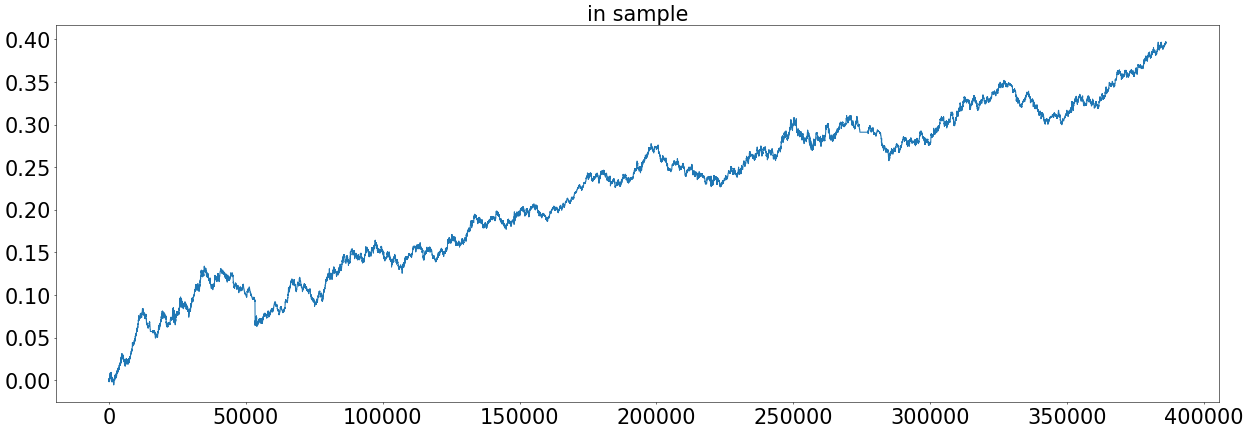

In [20]:
performance(equity_value_1[[(0.0015, -0.001, -0.015)]], transaction_history1[(0.0015, -0.001, -0.015)])
unrealized_return_train = unrealized(equity_value_1[(0.0015,-0.001,-0.015)], unrealized_1[(0.0015,-0.001,-0.015)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_train)
plt.title('in sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

return: 0.41464350702484326
std: 0.09676632239671926
sharp ratio: 4.231260389810215
trades: 223.0
odds ratio: 0.5291479820627802
mdd: 0.05693347800169518
skewness: -0.23099323782508338


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text xticklabel objects>)

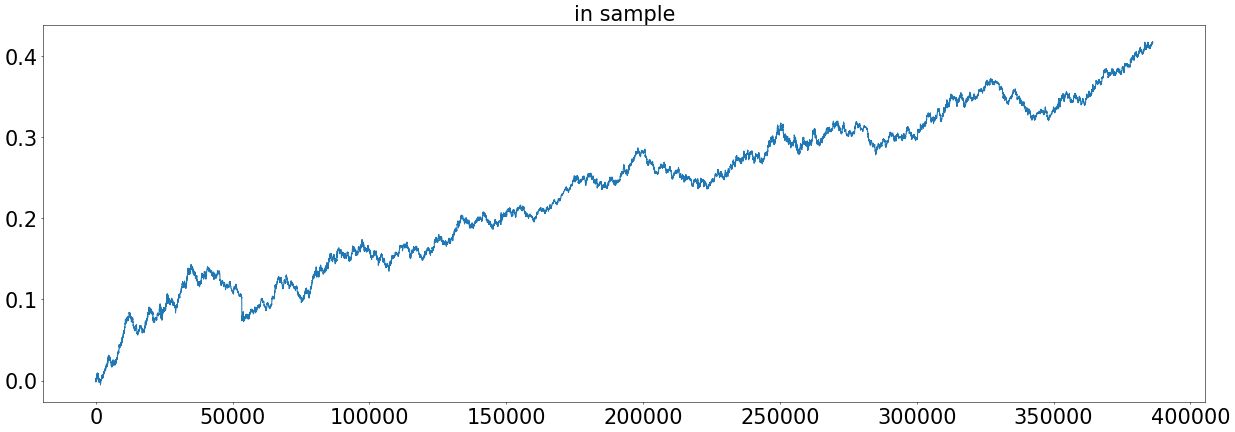

In [21]:
performance(equity_value_1[[(0.0015, -0.001, -0.02)]], transaction_history1[(0.0015, -0.001, -0.02)])
unrealized_return_train = unrealized(equity_value_1[(0.0015,-0.001,-0.02)], unrealized_1[(0.0015,-0.001,-0.02)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_train)
plt.title('in sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

return: 0.39927436891972445
std: 0.09624449419067889
sharp ratio: 4.094513376931331
trades: 144.0
odds ratio: 0.5833333333333334
mdd: 0.07895665706284799
skewness: -0.8537776690749468


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text xticklabel objects>)

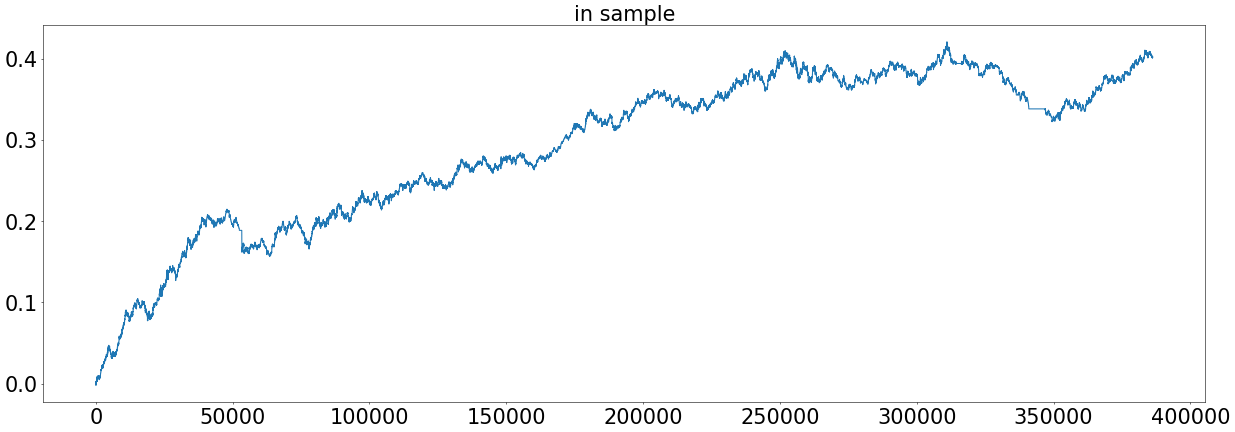

In [22]:
performance(equity_value_1[[(0.0015, -0.0015, -0.015)]], transaction_history1[(0.0015, -0.0015, -0.015)])
unrealized_return_train = unrealized(equity_value_1[(0.0015,-0.0015,-0.015)], unrealized_1[(0.0015,-0.0015,-0.015)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_train)
plt.title('in sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

return: 0.39133339139434686
std: 0.0953783638111276
sharp ratio: 4.048437989133312
trades: 144.0
odds ratio: 0.5833333333333334
mdd: 0.08443458040103341
skewness: -0.8474768671493529


(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text xticklabel objects>)

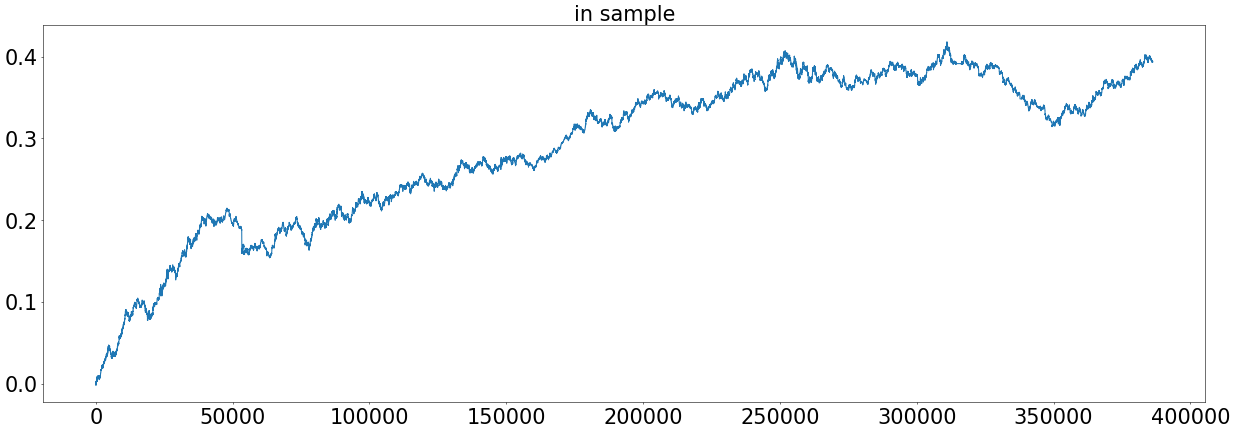

In [23]:
performance(equity_value_1[[(0.0015, -0.0015, -0.02)]], transaction_history1[(0.0015, -0.0015, -0.02)])
unrealized_return_train = unrealized(equity_value_1[(0.0015,-0.0015,-0.02)], unrealized_1[(0.0015,-0.0015,-0.02)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_train)
plt.title('in sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

In [24]:
profit_col = [(0.0015, -0.001, -0.015), (0.0015, -0.001, -0.02), (0.0015, -0.0015, -0.015), (0.0015, -0.0015, -0.02)]
equity_value_2, unrealized_2, transaction_history2 = strategy(df_test, profit_col)

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:629: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\us

C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ipykernel_launcher.py:673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user10\anaconda3\envs\VicGPU\lib\site-packages\ip

In [25]:
equity_value_2.columns = profit_col
unrealized_2.columns = profit_col
equity_value_2.iloc[-1]

(0.0015, -0.001, -0.015)    -0.061353
(0.0015, -0.001, -0.02)     -0.070267
(0.0015, -0.0015, -0.015)    0.002336
(0.0015, -0.0015, -0.02)     0.013765
Name: 106158, dtype: float64

return: 0.013765353673446359
std: 0.012643827886170545
sharp ratio: 0.6774335866130301
trades: 18.0
odds ratio: 0.3888888888888889
mdd: 0.03596185304887588
skewness: -0.301782894852627


(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 <a list of 8 Text xticklabel objects>)

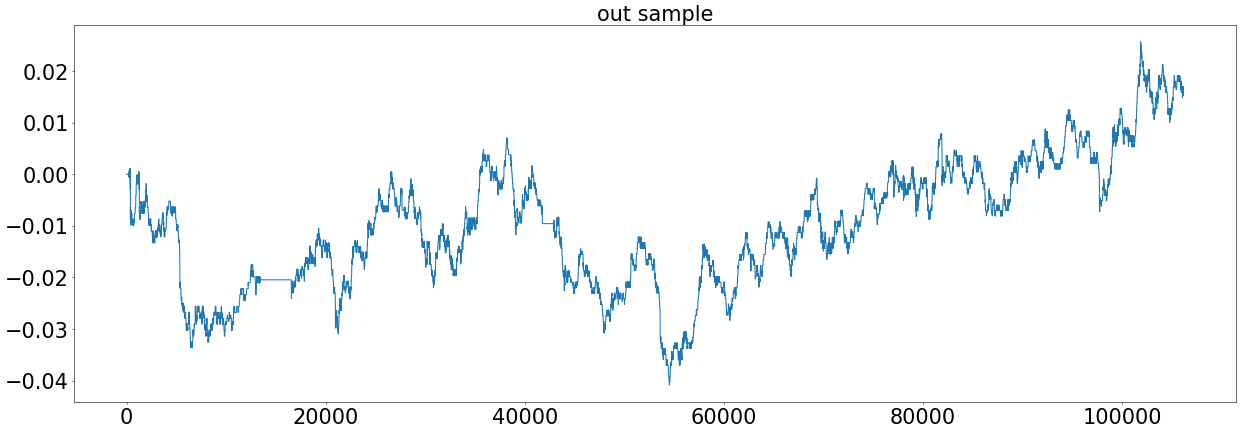

In [26]:
performance(equity_value_2[[(0.0015, -0.0015, -0.02)]], transaction_history2[(0.0015, -0.0015, -0.02)])
unrealized_return_test = unrealized(equity_value_2[(0.0015, -0.0015, -0.02)], unrealized_2[(0.0015, -0.0015, -0.02)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

return: -0.061353112229009174
std: 0.029223987214048543
sharp ratio: -2.2773453786968463
trades: 36.0
odds ratio: 0.4722222222222222
mdd: 0.09826112119012807
skewness: 0.4059814594275599


(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 <a list of 8 Text xticklabel objects>)

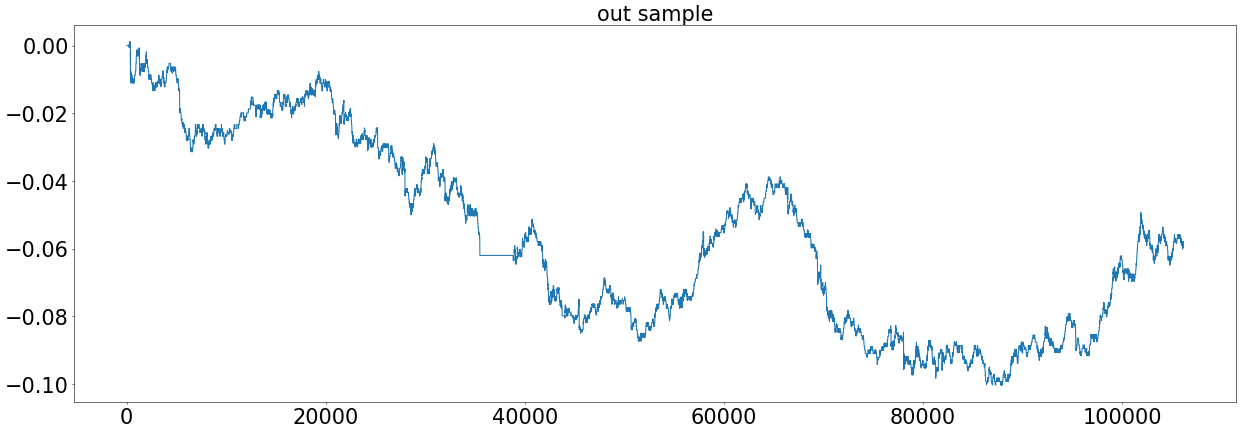

In [27]:
performance(equity_value_2[[(0.0015, -0.001, -0.015)]], transaction_history2[(0.0015, -0.001, -0.015)])
unrealized_return_test = unrealized(equity_value_2[(0.0015, -0.001, -0.015)], unrealized_2[(0.0015, -0.001, -0.015)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

return: -0.0702668304164704
std: 0.03311340677760202
sharp ratio: -2.2790415653491842
trades: 36.0
odds ratio: 0.4722222222222222
mdd: 0.1071748393775893
skewness: 0.38059366815301787


(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 <a list of 8 Text xticklabel objects>)

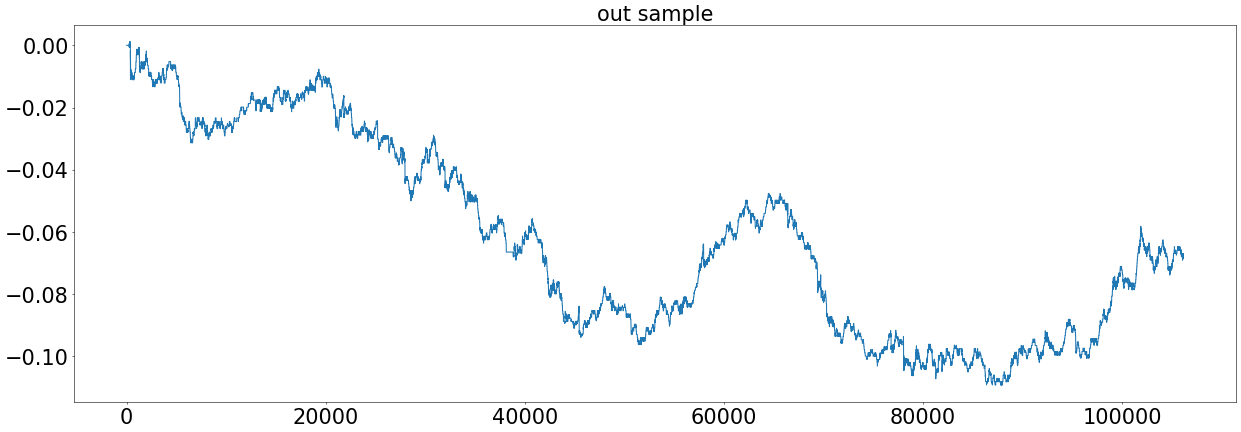

In [28]:
performance(equity_value_2[[(0.0015, -0.001, -0.02)]], transaction_history2[(0.0015, -0.001, -0.02)])
unrealized_return_test = unrealized(equity_value_2[(0.0015, -0.001, -0.02)], unrealized_2[(0.0015, -0.001, -0.02)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)

return: 0.002335613713372625
std: 0.012850872634498526
sharp ratio: -0.22289430205213068
trades: 19.0
odds ratio: 0.42105263157894735
mdd: 0.047391593008949615
skewness: -0.5470982097229482


(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 <a list of 8 Text xticklabel objects>)

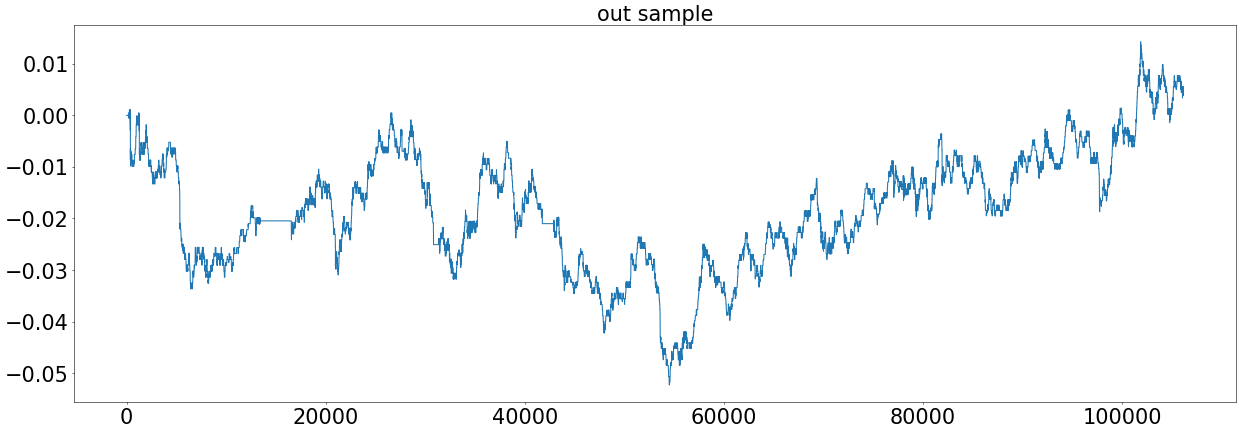

In [29]:
performance(equity_value_2[[(0.0015, -0.0015, -0.015)]], transaction_history2[(0.0015, -0.0015, -0.015)])
unrealized_return_test = unrealized(equity_value_2[(0.0015, -0.0015, -0.015)], unrealized_2[(0.0015, -0.0015, -0.015)])
plt.figure(figsize=(30,10),dpi=50)
plt.plot(unrealized_return_test)
plt.title('out sample', fontsize = 30)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)